In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import PolynomialFeatures
from modelo_cuadratico import modelo_cuadratico

### Funcioncitas

In [2]:
def position_of_item(itemid:int, matrix:pd.DataFrame):
    """
    Busca la posicion de un itemid en las columnas de la matriz de interacciones
    """
    try:
        pos = np.where(matrix.columns==itemid)[0].item()
    except:
        pos = None
    return pos

def position_of_user(userid:int, matrix:pd.DataFrame):
    """
    Busca la posicion de un userid en las filas de la matriz de interacciones
    """
    try:
        pos = np.where(matrix.index==userid)[0].item()
    except:
        pos = None
    return pos

In [3]:
def itemid_of_position(position:int, matrix:pd.DataFrame):
    """
    Busca el itemid de la posicion dada en la matriz de interacciones
    """
    try:
        itemid = matrix.columns[position]
    except:
        itemid = None
    return itemid

def userid_of_position(position:int, matrix:pd.DataFrame):
    """
    Busca el userid de la posicion dada en la matriz de interacciones
    """
    try:
        userid = matrix.index[position]
    except:
        userid = None
    return userid

### Proto Recomendador
Esta notebook está basada en el paper A Recommendation Model Based on Deep Neural Network del autor LIBO ZHANG

#### Prueba con datos creados

In [4]:
n_users = 50
n_items = 100
# TODO: Si a y b no son iguales se rompe. Ver por qué.
a = 20
b = 20
sparce_rate = .9 # Qué tan dispersa es la matriz de ratings de ejemplo

# Inicializo la matriz de interacciones y pongo -1 en muchos lugares
# El -1 representa las interacciones que no conocemos o no sucedieron. Ej: las peliculas que no vio el usuario.
ratings = np.random.randint(0, 2, n_users*n_items).reshape(n_users,n_items)
aux = np.random.rand(ratings.shape[0], ratings.shape[1])
ratings[aux<sparce_rate] = -1
ratings = torch.from_numpy(ratings)

In [5]:
model = modelo_cuadratico(a, b, n_users, n_items)

Using device: cuda


Epoch 37999 Loss: 0.021529840288355664  MAE: 0.16206821311103872
Early stopping en epoch 38664
Accuracy: 0.9847619047619047


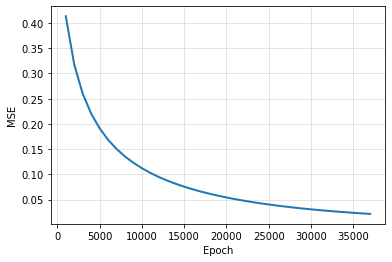

Wall time: 55.9 s


In [6]:
%time R = model.entrenar(ratings)

#### Prueba con datos de MovieLens

Uso el dataset de MovieLens 1M (https://grouplens.org/datasets/movielens/1m/).
Para correr esta notebook hay que bajarlo, descomprimirlo y apuntar los siguientes paths a los archivos correspondientes

In [7]:
user_data = '../../MovieLens/data/users.dat'
movie_data = '../../MovieLens/data/movies.dat'
ratings_data = '../../MovieLens/data/ratings.dat'

In [8]:
users = pd.read_csv(user_data, sep = '::', header = None, names = ['UserId', 'Gender', 'AgeGroup', 'Occupation', 'Zip'], encoding = 'latin-1')
movies = pd.read_csv(movie_data, sep = '::', header = None, names = ['MovieId', 'Title', 'Genre'], encoding = 'latin-1')
ratings_data = pd.read_csv(ratings_data, sep = '::', header = None, names = ['UserId', 'MovieId', 'Rating', 'Timestamp'], encoding = 'latin-1')

E:\Anaconda\envs\RecomendadorNN\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [9]:
ratings_data.head()

,UserId,MovieId,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [10]:
ratings_data['Match'] = (ratings_data['Rating']>=4).astype(int) # Considero un match si el ratings es 4 o más (esto es bastante burdo pero es para probar)

In [11]:
ratings_df = ratings_data.pivot(index='UserId',
                                 columns='MovieId',
                                 values='Match').fillna(-1)

In [12]:
ratings_df.head()

MovieId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserId,,,,,,,,,,,,,,,,,,,,,
1,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [13]:
ratings_matrix = ratings_df.to_numpy()

In [14]:
n_users = ratings_data.UserId.nunique()
n_items = ratings_data.MovieId.nunique()
a = 20
b = 20
l = a + b
ratings = ratings_matrix.copy()
ratings = torch.from_numpy(ratings)

In [15]:
model = modelo_cuadratico(a, b, n_users, n_items)

Using device: cuda


### Entrenamiento Regresión Cuadrática

Epoch 23999 Loss: 0.10083567307613422  MAE: 0.37369658557915897
Early stopping en epoch 24100
Accuracy: 0.7128530137201325


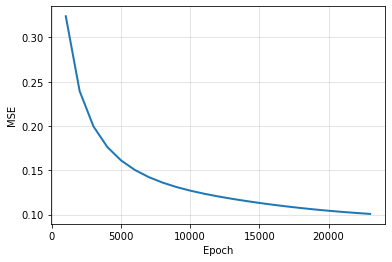

Wall time: 7min 11s


In [16]:
%time R = model.entrenar(ratings, lr = 0.1)